In [1]:
# import required libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import utils as sk_utils
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import cv2

from IPython.display import clear_output
clear_output()
print(tf.__version__)

2.14.0


In [2]:
# Directory containing the images
train_images_path = "dataset/bdd100k_seg/bdd100k/seg/images/train/*.jpg"
train_masks_path = "dataset/bdd100k_seg/bdd100k/seg/labels/train/*.png"
val_images_path = "dataset/bdd100k_seg/bdd100k/seg/images/val/*.jpg"
val_masks_path = "dataset/bdd100k_seg/bdd100k/seg/labels/val/*.png"

In [3]:
import glob
image_size = (192, 256)

# Load and preprocess the images
def load_image(file_path, is_x=False):
    # Read the image file using tf.io.read_file
    image = tf.io.read_file(file_path)
    # Decode the image into a tensor
    image = tf.image.decode_image(image)
    
    if is_x:
        # Resize the image to the desired size using Lanczos3 method
        image = tf.image.resize(image, image_size, method=tf.image.ResizeMethod.LANCZOS3)
        image = image / 255.0  # Normalize the image
    else:
        # Resize the image to the desired size using 'nearest' method
        image = tf.image.resize(image, image_size, method='nearest', antialias=True)
    return image

In [4]:
# load the training set

# Get the list of image file paths
image_paths = sorted(glob.glob(train_images_path))
mask_paths = sorted(glob.glob(train_masks_path))

# Shuffle the image_paths and mask_paths
image_paths, mask_paths = sk_utils.shuffle(image_paths, mask_paths, random_state=42)

# Create lists to store the loaded and preprocessed images
X_train = []
Y_train = []

# Apply the load_image function to each image path in the dataset
for x, y in zip(image_paths, mask_paths):
    X_train.append(load_image(x, True))
    Y_train.append(load_image(y))
    if len(X_train) % 500 == 0:
        print(len(X_train), 'data points loaded!')
else:
    print(len(X_train), 'data points loaded in total!')

# Convert the lists to NumPy arrays
X_train = np.array(X_train)
Y_train = np.array(Y_train)
# 255 is representing unknown objects
Y_train[Y_train == 255] = 19

500 data points loaded!
1000 data points loaded!
1500 data points loaded!
2000 data points loaded!
2500 data points loaded!
3000 data points loaded!
3500 data points loaded!
4000 data points loaded!
4500 data points loaded!
5000 data points loaded!
5500 data points loaded!
6000 data points loaded!
6500 data points loaded!
7000 data points loaded!
7000 data points loaded in total!


In [5]:
# load the validataion set (1000 observations)

# Get the list of image file paths
image_paths = sorted(glob.glob(val_images_path))
mask_paths = sorted(glob.glob(val_masks_path))

# Shuffle the image_paths and mask_paths
image_paths, mask_paths = sk_utils.shuffle(image_paths, mask_paths, random_state=42)

# Create lists to store the loaded and preprocessed images
X_val = []
Y_val = []

# Apply the load_image function to each image path in the dataset
for x, y in zip(image_paths, mask_paths):
    X_val.append(load_image(x, True))
    Y_val.append(load_image(y))
    if len(X_val) == 500:
        print(len(X_val), 'data points loaded!')
else:
    print(len(X_val), 'data points loaded in total!')

# Convert the lists to NumPy arrays
X_val = np.array(X_val)
Y_val = np.array(Y_val)
# 255 is representing unknown objects
Y_val[Y_val == 255] = 19

500 data points loaded!
1000 data points loaded in total!


In [6]:
print('X train:', X_train.shape)
print('Y train:', Y_train.shape)
print('X val:', X_val.shape)
print('Y val:', Y_val.shape)

X train: (7000, 192, 256, 3)
Y train: (7000, 192, 256, 1)
X val: (1000, 192, 256, 3)
Y val: (1000, 192, 256, 1)


In [7]:
# Utils
import numpy as np
import matplotlib.pyplot as plt

color_dict = {
    0: (0.7, 0.7, 0.7),     # road - gray
    1:  (0.9, 0.9, 0.2),     # sidewalk - light yellow
    2: (1.0, 0.4980392156862745, 0.054901960784313725),
    3: (1.0, 0.7333333333333333, 0.47058823529411764),
    4: (0.8, 0.5, 0.1),  # Fence - rust orange
    5: (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
    6: (0.325, 0.196, 0.361),
    7: (1.0, 0.596078431372549, 0.5882352941176471),
    8:  (0.2, 0.6, 0.2),     # vegetation - green
    9: (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
    10: (0.5, 0.7, 1.0),     # sky - light blue
    11: (1.0, 0.0, 0.0), # person - red
    12: (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
    13: (0.0, 0.0, 1.0),  # Car - blue
    14: (0.0, 0.0, 1.0),  # Track - blue
    15: (0.0, 0.0, 1.0),  # Bus - blue
    16: (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
    17: (0.8588235294117647, 0.8588235294117647, 0.5529411764705883),
    18: (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
    19: (0, 0, 0) # unknown - black
}

def colorize_image(image, color_dict):
    # remove the extra dimension
    image = np.squeeze(image)
    # Generate the colored image using the color dictionary
    colored_image = np.zeros((image.shape[0], image.shape[1], 3))

    for pixel_value, color in color_dict.items():
        colored_image[image == pixel_value] = color

    # Convert the image to 8-bit unsigned integer
    colored_image = (colored_image * 255).astype(np.uint8)

    return colored_image

In [ ]:
# visualize some samples from the training set
plt.figure(figsize=(10, 40))
s, e = 80, 84
index = 1

for i, j in zip(X_train[s:e], Y_train[s:e]):
    plt.subplot(10, 2, index)
    plt.imshow(i)
    plt.title('Ground truth image')
    
    plt.subplot(10, 2, index+1)
    plt.imshow(colorize_image(j, color_dict))
    plt.title('Ground truth mask')
    index += 2

In [ ]:
# visualize some samples from the validation set
plt.figure(figsize=(10, 40))
s, e = 10, 14
index = 1

for i, j in zip(X_val[s:e], Y_val[s:e]):
    plt.subplot(10, 2, index)
    plt.imshow(i)
    plt.title('Ground truth image')
    
    plt.subplot(10, 2, index+1)
    plt.imshow(colorize_image(j, color_dict))
    plt.title('Ground truth mask')
    index += 2

In [10]:
# free the RAM by collecting the garbage
import gc
gc.collect()

48047

In [11]:
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, Concatenate
from keras.models import Model

def unet(input_size=(*image_size,3)):
    inputs = Input(input_size)
    
    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    # Decoder
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)
    
    up6 = Conv2DTranspose(512, 3, strides=2, activation='relu', padding='same', kernel_initializer='he_normal')(drop5)
    merge6 = Concatenate(axis=3)([conv4, up6])
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
    
    up7 = Conv2DTranspose(256, 3, strides=2, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
    merge7 = Concatenate(axis=3)([conv3, up7])
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
    
    up8 = Conv2DTranspose(128, 3, strides=2, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
    merge8 = Concatenate(axis=3)([conv2, up8])
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
    
    up9 = Conv2DTranspose(64, 3, strides=2, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
    merge9 = Concatenate(axis=3)([conv1, up9])
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    
    outputs = Conv2D(20, 1, activation='softmax')(conv9)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    return model

model = unet()

# Compile the model

model.compile(optimizer='adam', loss=keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 192, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 192, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 192, 256, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 96, 128, 64)          0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [12]:
# model = tf.keras.models.load_model('/kaggle/input/road-segmentation-for-adas-bdd100k-cpu/trained_model_32_cpu.h5')
# model.compile(optimizer=keras.optimizers.Adam(0.0001), loss=keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
# model.summary()

In [13]:
# train the model
epochs = 5
batch_size = 16

model.fit(
    X_train,
    Y_train,
    epochs=epochs,
    validation_data=(X_val, Y_val),
    batch_size=batch_size
)

Epoch 1/5
438/438 [==============================] - 9224s 21s/step - loss: 1.3645 - accuracy: 0.5652 - val_loss: 1.0216 - val_accuracy: 0.6869
Epoch 2/5
438/438 [==============================] - 9388s 21s/step - loss: 0.9684 - accuracy: 0.7107 - val_loss: 0.8974 - val_accuracy: 0.7328
Epoch 3/5
438/438 [==============================] - 8926s 20s/step - loss: 0.8578 - accuracy: 0.7479 - val_loss: 0.7509 - val_accuracy: 0.7710
Epoch 4/5
438/438 [==============================] - 8520s 19s/step - loss: 0.7976 - accuracy: 0.7677 - val_loss: 0.6761 - val_accuracy: 0.7996
Epoch 5/5
438/438 [==============================] - 8612s 20s/step - loss: 0.7495 - accuracy: 0.7839 - val_loss: 0.6539 - val_accuracy: 0.8046


In [14]:
Y_pred = model.predict(X_val)
Y_pred = np.argmax(Y_pred, axis=-1).reshape(-1, *image_size, 1)

32/32 [==============================] - 380s 12s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


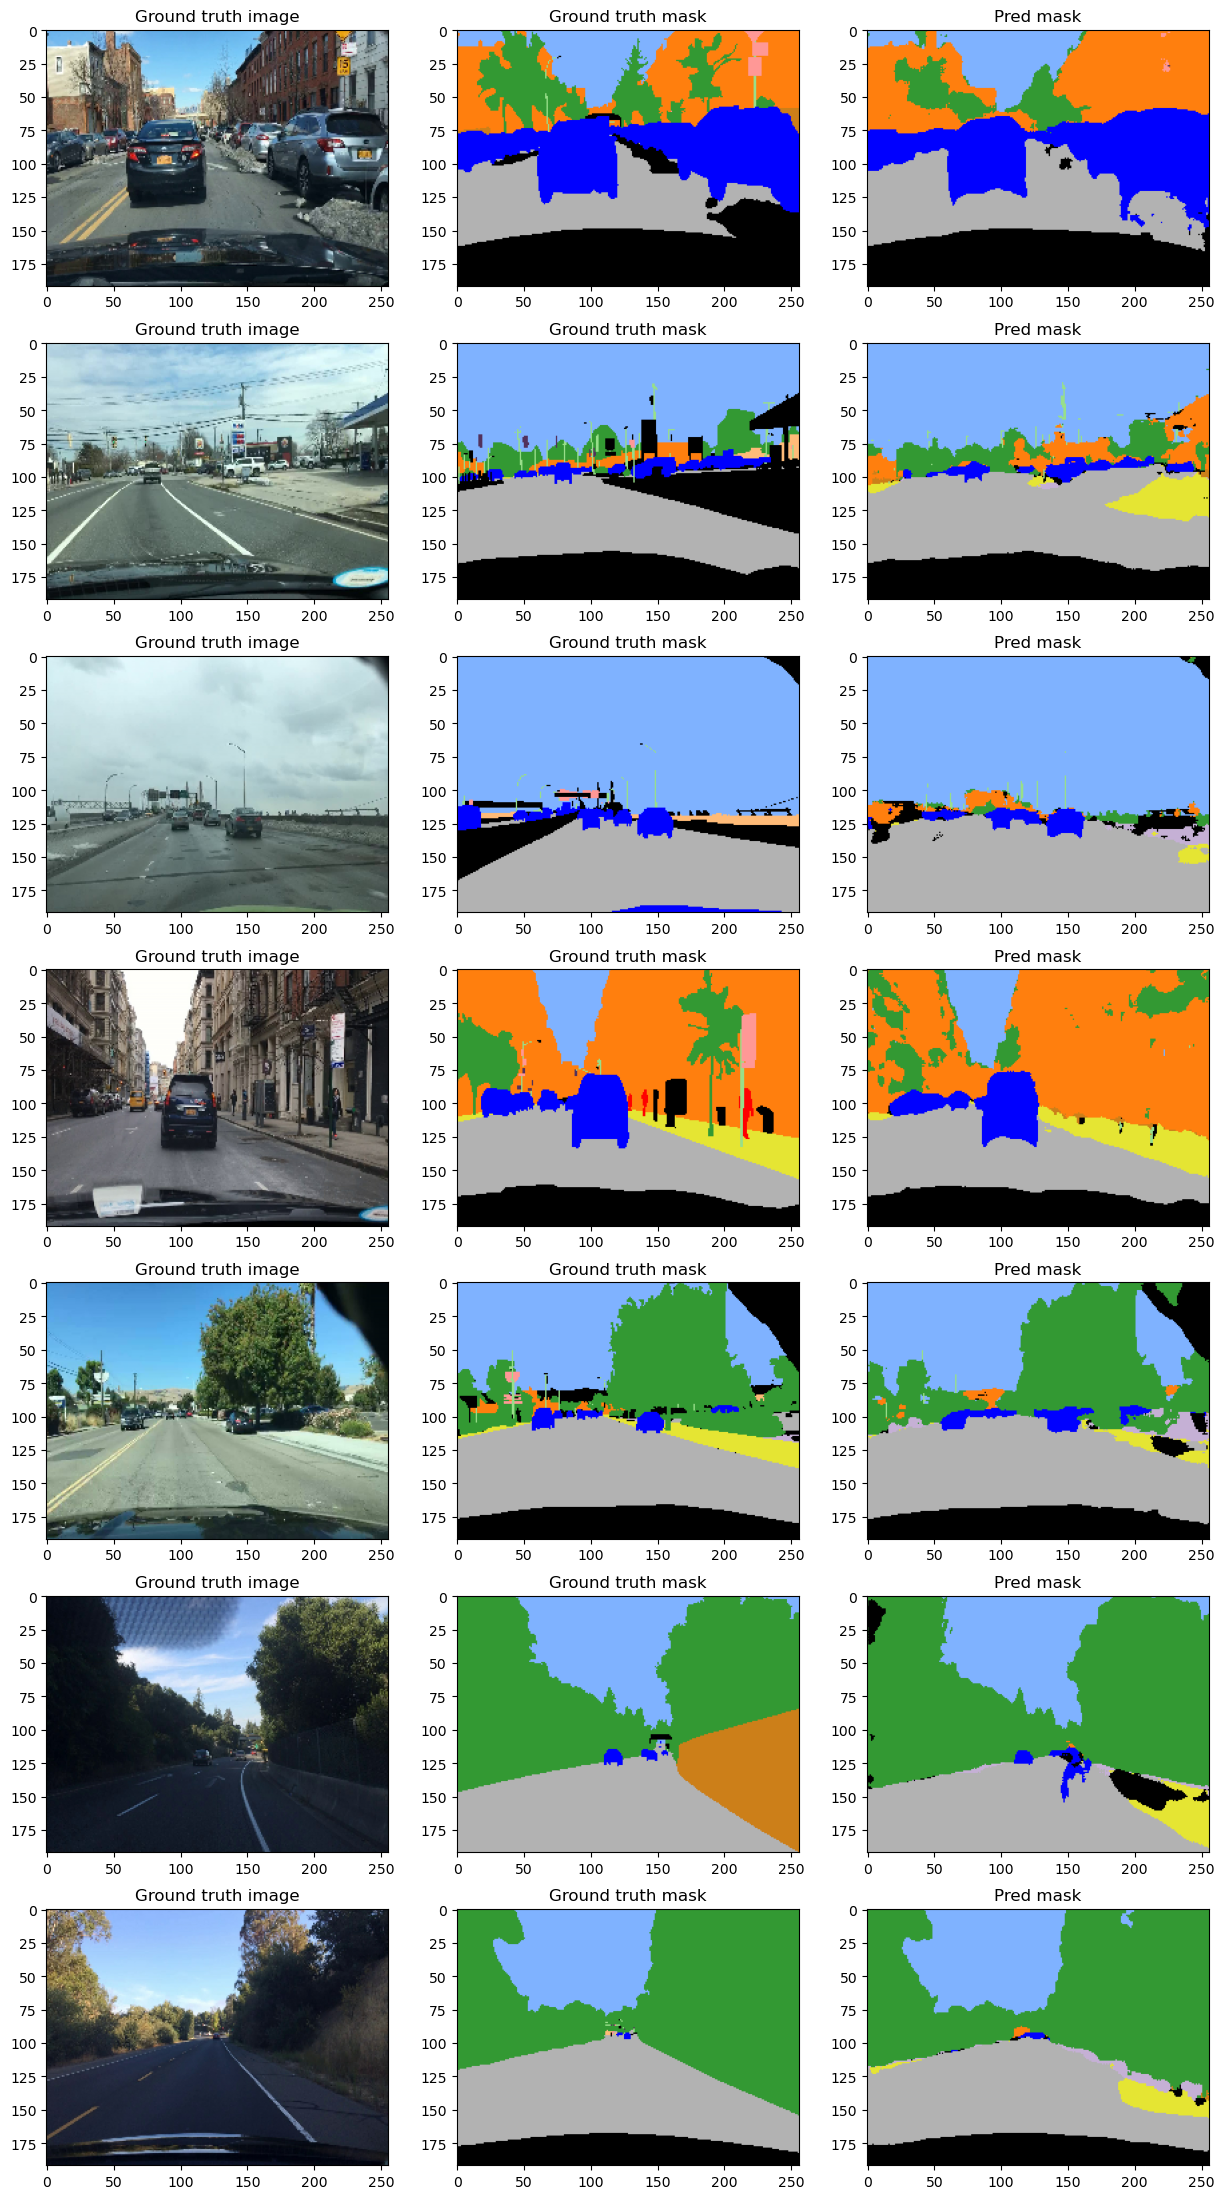

In [15]:
# visualize some results from the validation set.
plt.figure(figsize=(15, 40))
s, e = 1, 8
index = 1

for i, j, k in zip(X_val[s:e], Y_pred[s:e], Y_val[s:e]):
    
    # write these images into file as well
    cv2.imwrite(f'./out/img-{index}.jpg', i)
    cv2.imwrite(f'./out/pred-{index}.png', j)
    cv2.imwrite(f'./out/ground-{index}.png', k)
    
    plt.subplot(10, 3, index)
    plt.imshow(i)
    plt.title('Ground truth image')
    
    plt.subplot(10, 3, index+1)
    plt.imshow(colorize_image(k, color_dict))
    plt.title('Ground truth mask')
    
    plt.subplot(10, 3, index+2)
    plt.imshow(colorize_image(j, color_dict))
    plt.title('Pred mask')
    index += 3

In [16]:
from tensorflow.keras.metrics import MeanIoU, Accuracy

num_classes = 20

def compute_metrics(gt_masks, pred_masks):
    # Reshape the masks to (batch_size, height, width)
    gt_masks_reshaped = tf.reshape(gt_masks, [-1, tf.shape(gt_masks)[-1]])
    pred_masks_reshaped = tf.reshape(pred_masks, [-1, tf.shape(pred_masks)[-1]])

    # Compute accuracy
    accuracy_metric = Accuracy()
    accuracy_metric.update_state(gt_masks_reshaped, pred_masks_reshaped)
    accuracy = accuracy_metric.result().numpy()

    # Compute mean IoU
    iou_metric = MeanIoU(num_classes=num_classes)
    iou_metric.update_state(gt_masks_reshaped, pred_masks_reshaped)
    miou = iou_metric.result().numpy()

    return accuracy, miou

# Example usage
# Assuming you have ground_truth_masks and predicted_masks as TensorFlow tensors

accuracy, miou = compute_metrics(Y_val, Y_pred)

# Print the metric values
print("Accuracy:", accuracy)
print("Mean IoU:", miou)

Accuracy: 0.8046387
Mean IoU: 0.25170463


In [17]:
# save the model
model.save('asad_epoch5.h5')

c:\Users\CS3-36\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
